<h1 style="color:#000066; font-size:250%;">
    <center>
        <ins>
            Introduction to Data Science - Method and Tools
        </ins>
    </center>
</h1>

<h1 style="color:#000066; font-size:250%;">
    <center>
        <ins>
            Stock's Prediction
        </ins>
    </center>
</h1>

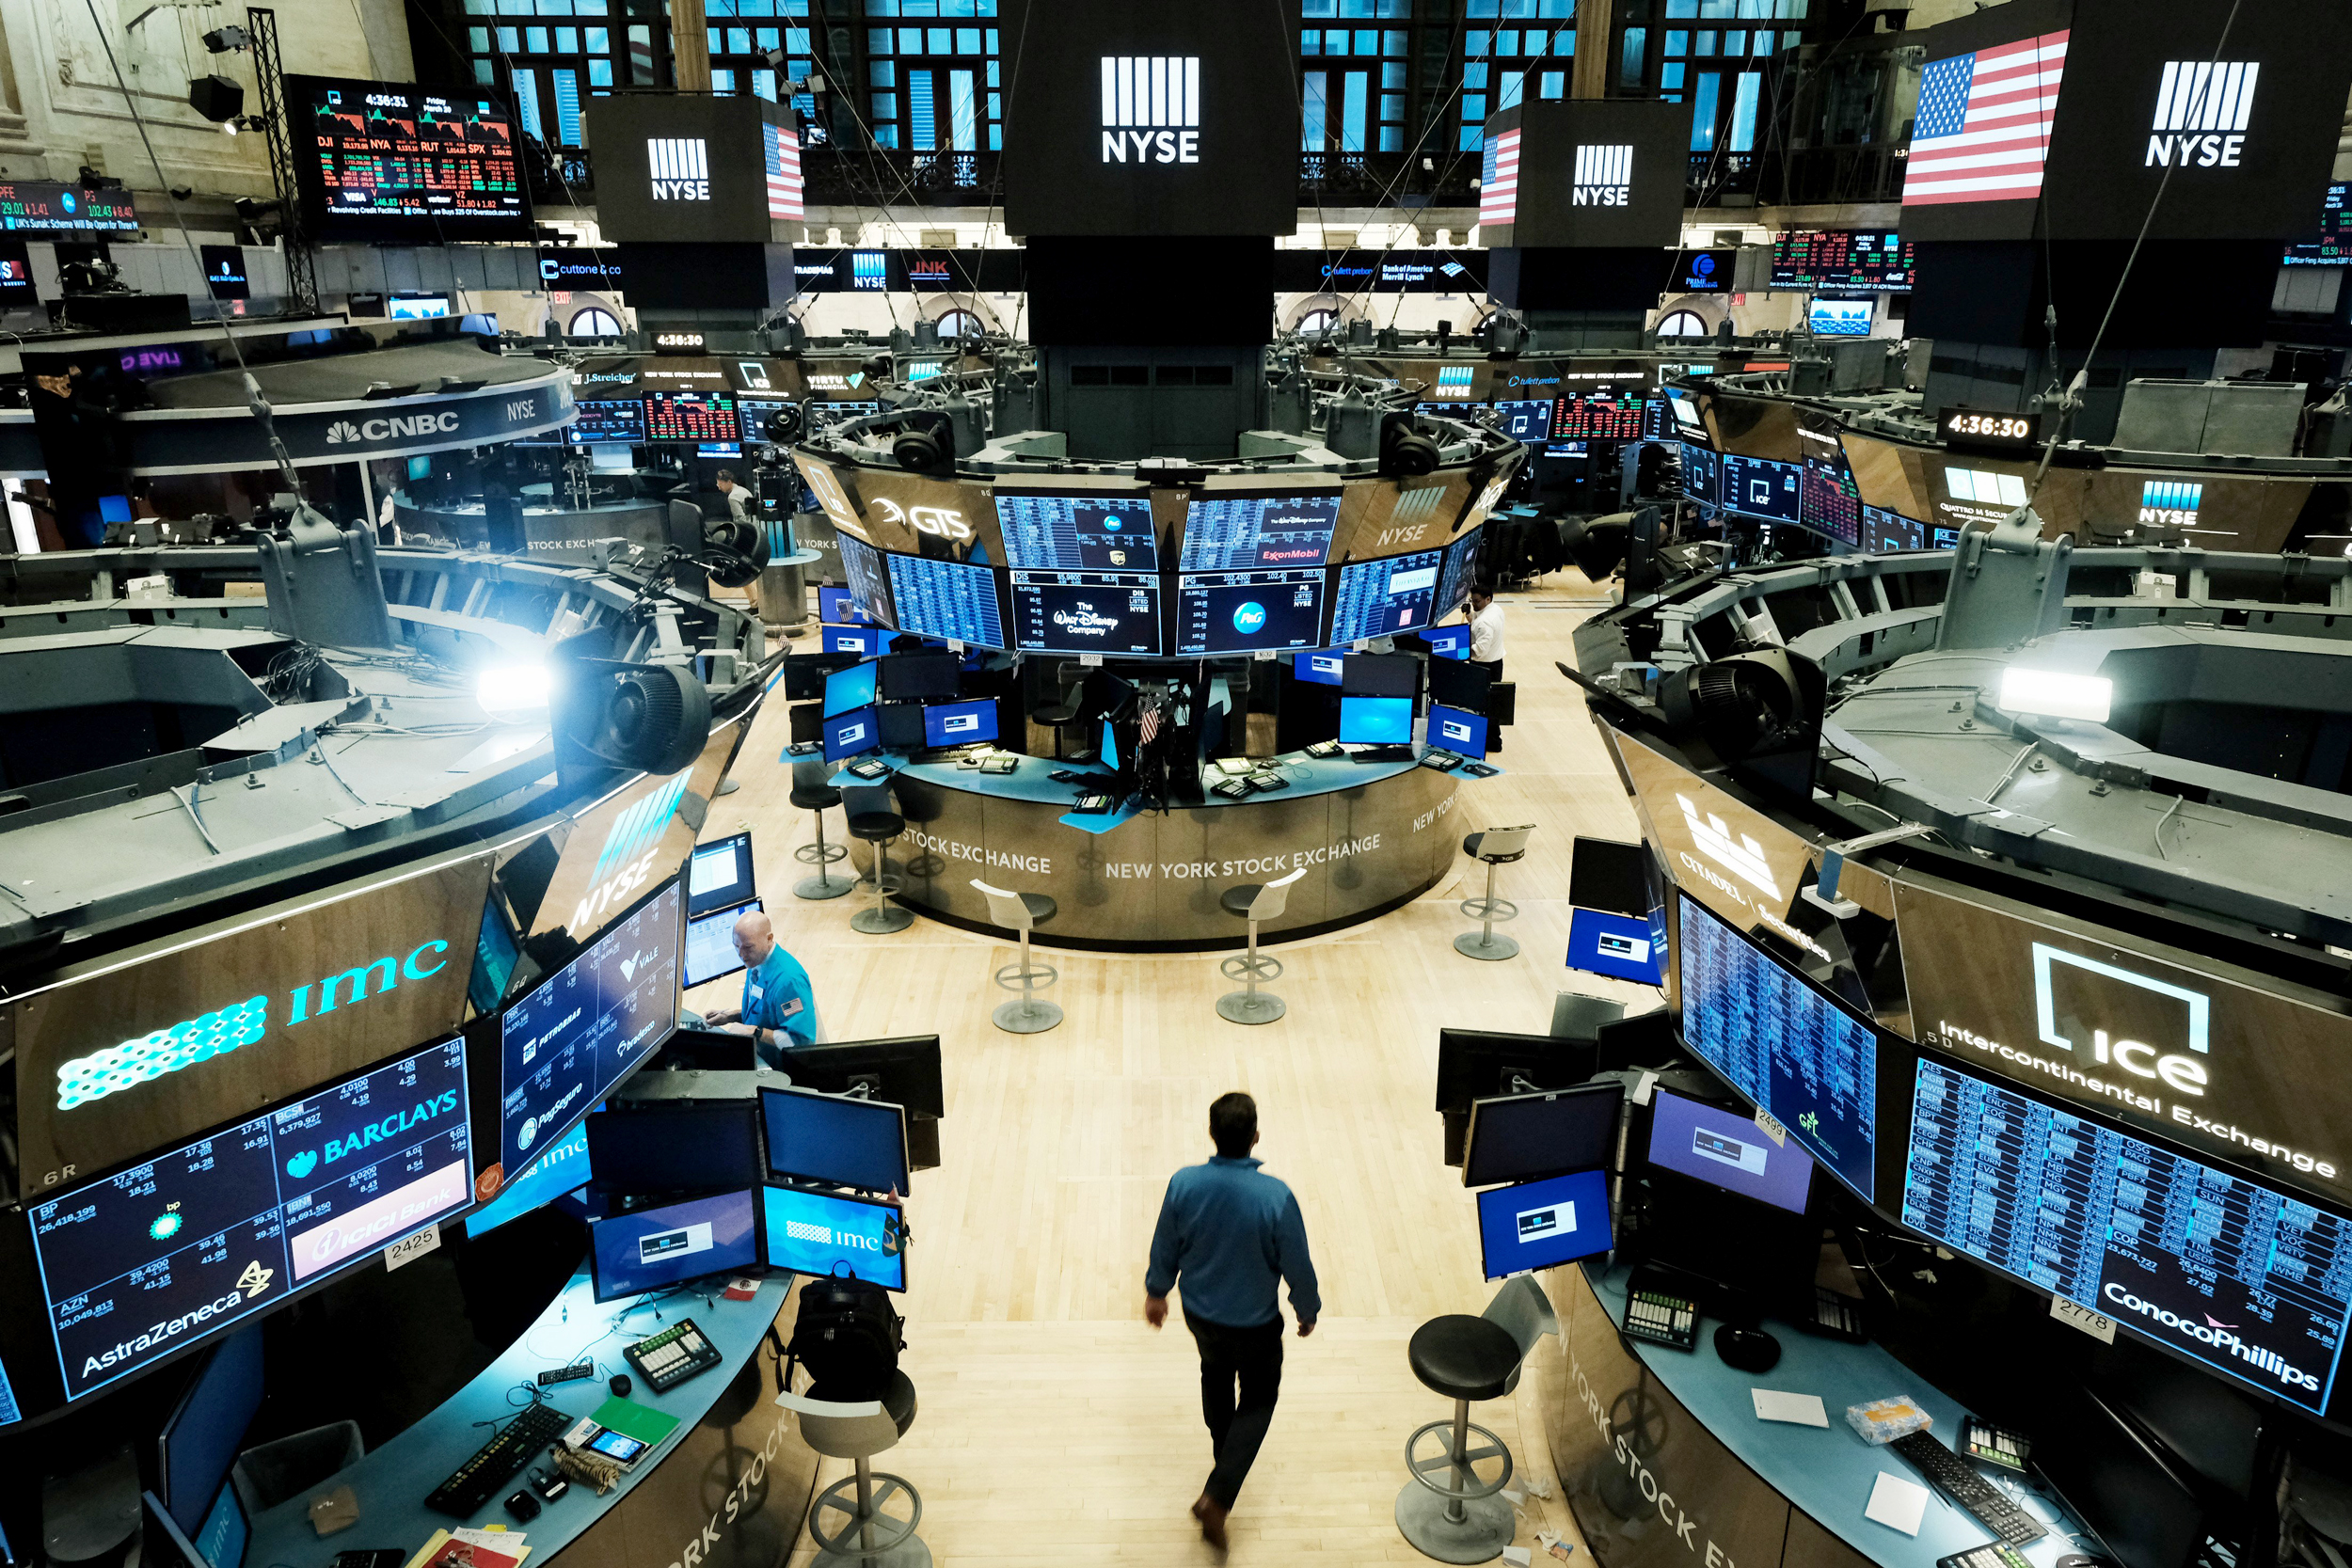

<body>
    <h3 style="color:#000066;"><ins>The research question we will focus on is:</ins></h3>
    <p style="font-size:200%; text-align:center;">
        <b>
            <mark style="background-color:yellow; color:purple;">
                can we predict future stock trend?
            </mark>
        </b>
    </p>
</body>


### During the project we came across additional questions that were answered like:

1. How much The Stock value changed in 10 years?                
2. What was the correlation between different stocks?


## Importing Libraries List -

In [1]:
import pandas as pd
import numpy as np
from selenium import webdriver
from bs4 import BeautifulSoup
import time
import os
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

%matplotlib inline

# Method 1 -
 
We pulled out the information for 4 different stocks from "Yahoo Finance" using selenium, Then created one DataFrame that

combines them all, in the main Jupyter notebook you can use Selenium method.

## Reading the data from CSV we already created using Method 1.

In [2]:
# Reading Data Frames from folder..
company_df = []
stock_code = ['AAPL', 'NFLX', 'MA', 'TSLA']
stock_name = ['Apple', 'Netflix', 'Mastercard', 'Tesla']

for code, name in zip(stock_code, stock_name):
    globals()[code] = pd.read_csv(f"{name}.csv",index_col = 0)
    company_df.append(globals()[code])
    
stock_data = pd.read_csv("Stocks_Data.csv",index_col = 0)

# Basic Info - Stock_data 

1. Open - The Stock starting price at the same day.
2. High - The highest value that the Stock reached at the same day.
3. Low - As high but the lowest.
4. Close - The Stock Price when the working day over.
5. Adj Close - After the stock exchange closes there can still be changes in the share price, the parameter perfects all possible changes and determines the value of the share at the end of the working day.
6. Volume - This parameter indicates how much the stock is tradable - the more the better.
7. Company - Company's name.

In [3]:
stock_data

Date    Open    High     Low   Close  Adj Close     Volume  \
0     Jan 11 2022  172.32  175.18  170.82  175.08     175.08   76015600   
1     Jan 10 2022  169.08  172.50  168.17  172.19     172.19  106765600   
2     Jan 07 2022  172.89  174.14  171.03  172.17     172.17   86580100   
3     Jan 06 2022  172.70  175.30  171.64  172.00     172.00   96904000   
4     Jan 05 2022  179.61  180.17  174.64  174.92     174.92   94537600   
...           ...     ...     ...     ...     ...        ...        ...   
2294  Nov 30 2012    6.73    6.86    6.60    6.76       6.76    7101500   
2295  Nov 29 2012    6.69    6.80    6.57    6.74       6.74    5517000   
2296  Nov 28 2012    6.40    6.86    6.38    6.65       6.65    7626000   
2297  Nov 27 2012    6.43    6.53    6.30    6.43       6.43    4554000   
2298  Nov 26 2012    6.42    6.46    6.32    6.45       6.45    2479000   

     Company  
0      Apple  
1      Apple  
2      Apple  
3      Apple  
4      Apple  
...      ...  
2294   Tesla  
2295   Tesla  
2296   Tesla  
2297   Tesla  
2298   Tesla  

[9423 rows x 8 columns]

## Now let's Explore and take care of our data

In [4]:
stock_data.info() # Our data is full no missing value - Great!

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9423 entries, 0 to 2298
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9423 non-null   object 
 1   Open       9423 non-null   float64
 2   High       9423 non-null   float64
 3   Low        9423 non-null   float64
 4   Close      9423 non-null   float64
 5   Adj Close  9423 non-null   float64
 6   Volume     9423 non-null   int64  
 7   Company    9423 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 662.6+ KB


In [7]:
stock_data.duplicated().sum() # no duplicated rows

0

### Correlation for each stock separately, comaparing each column with each other.

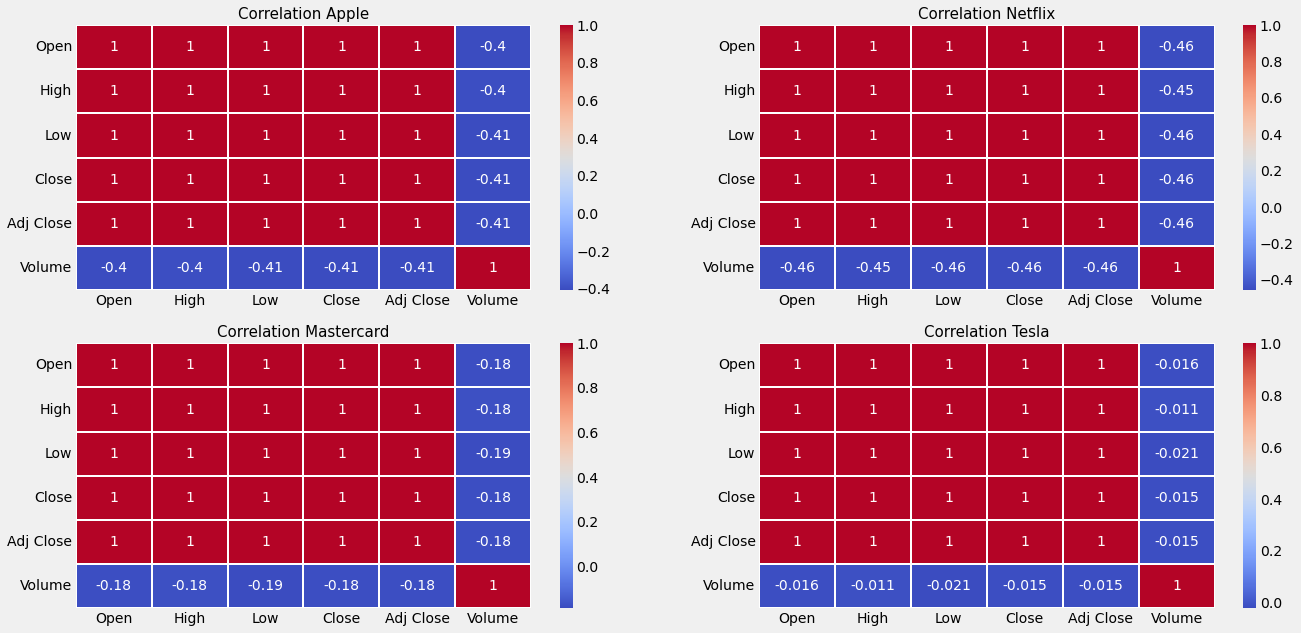

In [16]:
Numeric_cat = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for i in range(0,4):
    comp = (stock_data.loc[stock_data['Company'] == stock_name[i]])[Numeric_cat]
    plt.subplot(2, 2, i+1)
    plt.title(f"Correlation {stock_name[i]}", fontsize = 15)
    sns.heatmap(comp.corr() , annot = True, cmap = 'coolwarm', linewidth = 0.25)

### Outliers - Using  IQR Method.

In [15]:
for i in range(4):
    print(f"Looking for outliers in {stock_name[i]}[Close] stock: ")
    comp = (stock_data.loc[stock_data['Company'] == stock_name[i]])["Close"]
    Q1 = np.percentile(comp , 25)
    Q3 = np.percentile(comp , 75)
    IQR = Q3 -Q1
    Fare_outlier_rows = comp[(comp < Q1-1.5*IQR) | (comp > Q3 + 1.5*IQR)].index
    print(len(Fare_outlier_rows))
    print("-----")

Looking for outliers in Apple[Close] stock: 
365
-----
Looking for outliers in Netflix[Close] stock: 
0
-----
Looking for outliers in Mastercard[Close] stock: 
0
-----
Looking for outliers in Tesla[Close] stock: 
473
-----


### Stocks can behave in an extreme way, both in terms of rise or fall and therefore we will not address the same "Outliers" that we have identified.
### Dealing with them can hurt our level of prediction. any important information.

# EDA - for stock_data

### Describing each of Company Close data separately.

In [8]:
for comp,i in zip(company_df,stock_name):
    print(f"Describing {i} Close Data")
    print(comp['Close'].describe())
    print("-----")

Describing Apple Close Data
count    2262.000000
mean       52.744187
std        40.125051
min        13.950000
25%        26.272500
50%        38.190000
75%        58.447500
max       182.010000
Name: Close, dtype: float64
-----
Describing Netflix Close Data
count    2599.000000
mean      207.151016
std       184.534255
min         7.690000
25%        51.870000
50%       124.050000
75%       351.345000
max       691.690000
Name: Close, dtype: float64
-----
Describing Mastercard Close Data
count    2263.000000
mean      175.691233
std       105.151247
min        50.970000
25%        87.880000
50%       127.430000
75%       272.935000
max       395.650000
Name: Close, dtype: float64
-----
Describing Tesla Close Data
count    2299.000000
mean      157.427995
std       250.472827
min         6.430000
25%        42.060000
50%        52.000000
75%        71.470000
max      1229.910000
Name: Close, dtype: float64
-----


### histograms of "Close" Column for each stock.
#### Here you can see the stock price most of the time, regardless of time but the amount in which the price range repeats (relative frequency).

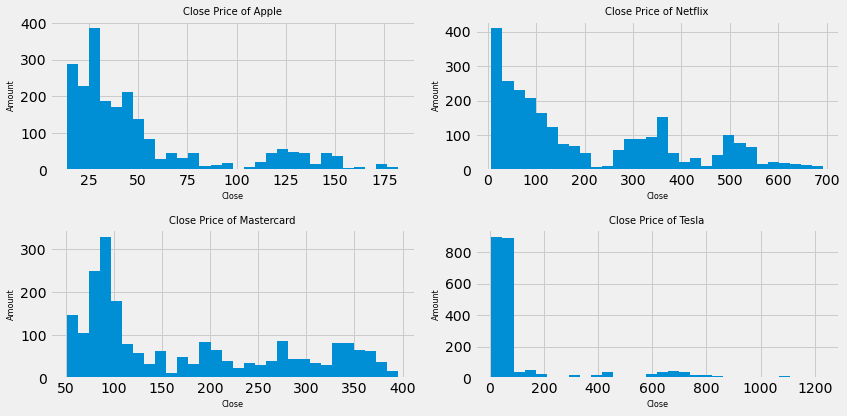

In [17]:
plt.figure(figsize=(12, 6))
plt.subplots_adjust(top=2.5, bottom=1.7)
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('fivethirtyeight')

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.hist((stock_data.loc[stock_data['Company'] == stock_name[i]])["Close"], bins = 30)
    plt.ylabel('Amount',fontsize = 8)
    plt.xlabel('Close',fontsize = 8)
    plt.title(f"Close Price of {stock_name[i]}", fontsize = 10)
    
plt.tight_layout()

# All Stocks "Close" through the years...

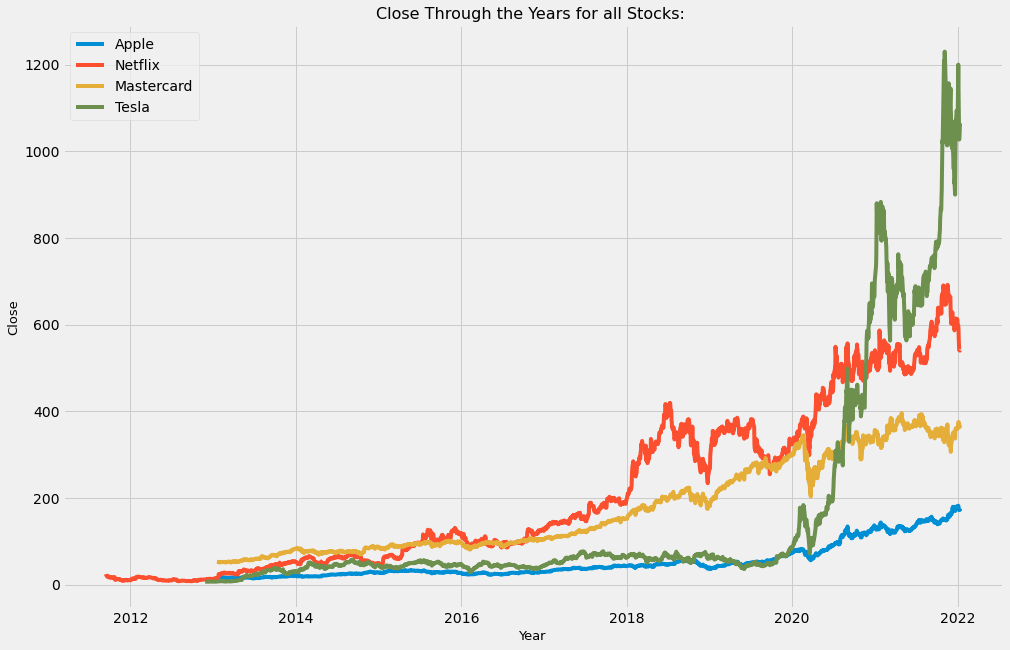

In [35]:
plt.figure(figsize = (15,10))
b = ['Date','Close']
arr = []
for i in range(4):
    comp = (stock_data.loc[stock_data['Company'] == stock_name[i]])[b]
    arr.append(comp)
    
for i in range(4):
    arr[i]['Date'] = pd.to_datetime(arr[i]['Date'])
    plt.plot(arr[i]['Date'], arr[i]['Close'], label=stock_name[i])
    plt.legend(loc='best')
    plt.ylabel('Close',fontsize = 13)
    plt.xlabel('Year',fontsize = 13)
    plt.title(f"Close Through the Years for all Stocks: ", fontsize = 16)
plt.show()

### From the "basic information" we mentioned earlier,
### it can be clearly seen that there is a relationship between all the "stock_data" columns except one "volume".
### So we used Scatterplot to find the type of relationship, and we found out that there is none.

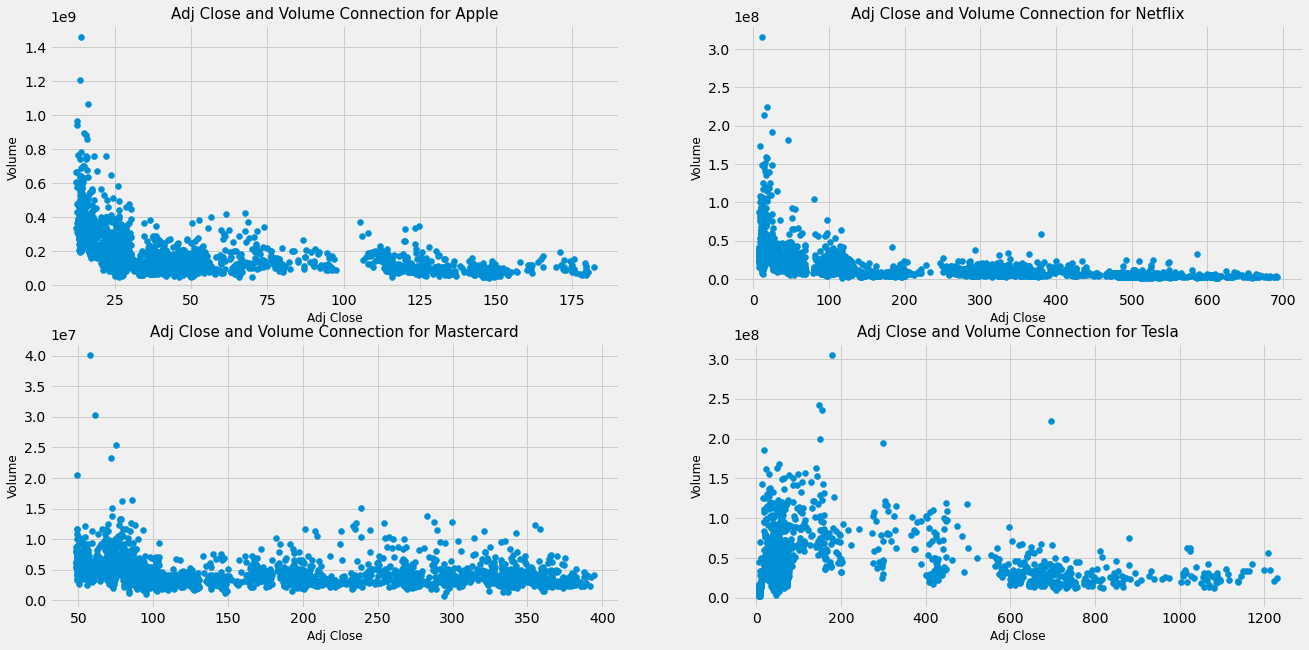

In [14]:
for i in range(4):
    comp = stock_data[stock_data["Company"] == stock_name[i]]
    plt.subplot(2, 2, i+1)
    plt.scatter(comp["Adj Close"], comp["Volume"])
    plt.ylabel('Volume',fontsize = 12)
    plt.xlabel("Adj Close",fontsize = 12)
    plt.title(f"Adj Close and Volume Connection for {stock_name[i]}", fontsize = 15)

## Total volume of each stock bieng traded each day

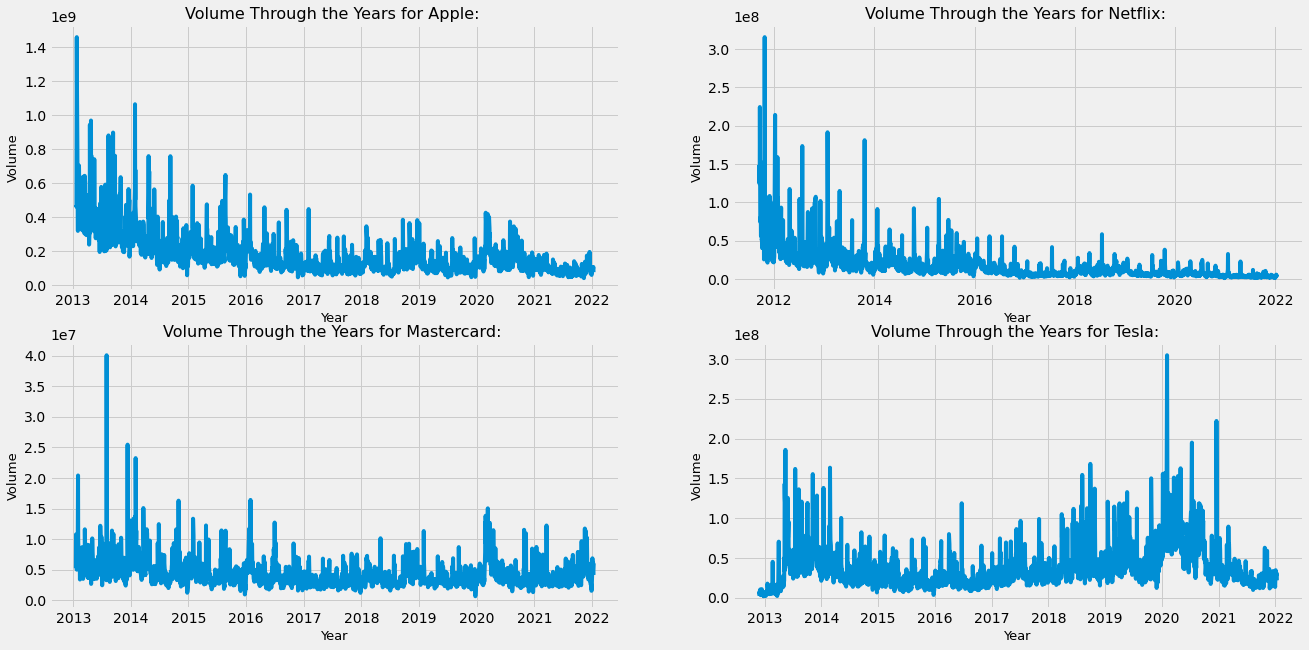

In [20]:
for i in range(4):
    comp = stock_data[stock_data["Company"] == stock_name[i]].copy()
    comp['Date'] = pd.to_datetime(comp['Date'])
    plt.subplot(2, 2, i+1)
    plt.plot(comp['Date'], comp['Volume'], label=stock_name[i])
    plt.ylabel('Volume',fontsize = 13)
    plt.xlabel('Year',fontsize = 13)
    plt.title(f"Volume Through the Years for {stock_name[i]}: ", fontsize = 16)

### We can see here that during the year all stock volume went down except Tesla that during the Covid - 19 traded more and the stock volume grew bigger. 

### Checking the Correlation between the stock on "Close" Column.

<AxesSubplot:>

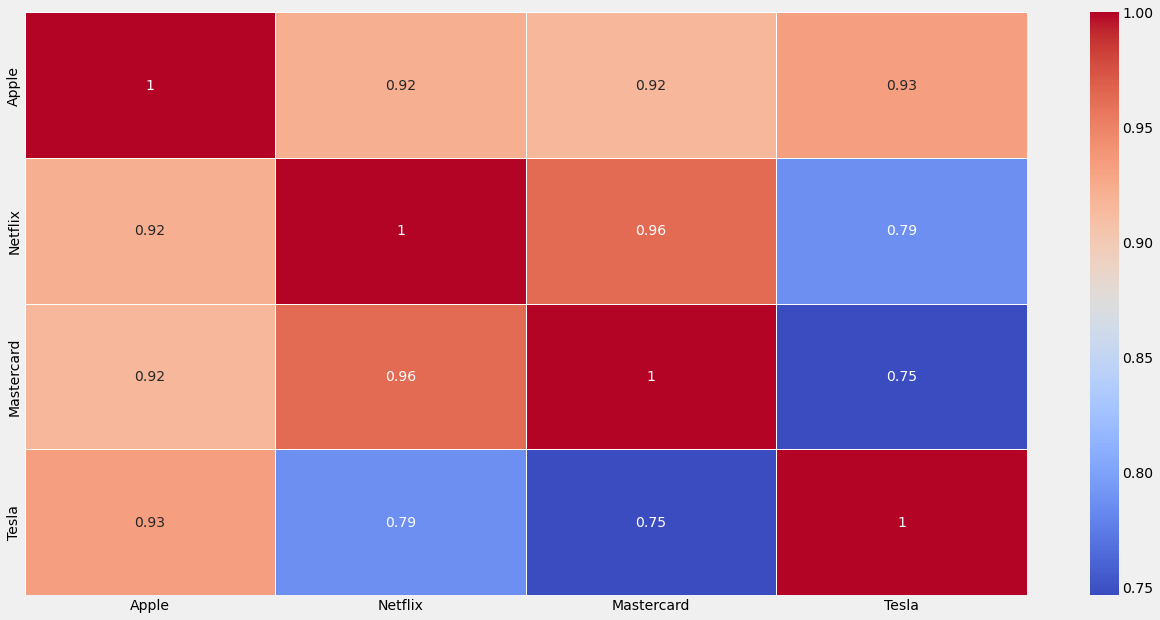

In [22]:
min_arr = []
cat = ['Date','Company']
for i in range(4):
    x = (stock_data.loc[stock_data['Company'] == stock_name[i]])[cat]
    min_arr.append(x.shape[0])
    
index = np.argmin(min_arr)
df_new = (stock_data.loc[stock_data['Company'] == stock_name[index]])["Date"]
df_new = df_new.to_frame()

for i in range(4):
    df_new[stock_name[i]] = (stock_data.loc[stock_data['Company'] == stock_name[i]])["Close"]

sns.heatmap(df_new.corr() , annot = True, cmap = 'coolwarm', linewidth = 0.5)

### Here is also the df_new details, Showing "Close" column from each stock.

In [23]:
df_new

Date   Apple  Netflix  Mastercard    Tesla
0     Jan 11 2022  175.08   540.84      366.29  1064.40
1     Jan 10 2022  172.19   539.85      363.91  1058.12
2     Jan 07 2022  172.17   541.06      369.65  1026.96
3     Jan 06 2022  172.00   553.29      370.00  1064.70
4     Jan 05 2022  174.92   567.52      373.90  1088.12
...           ...     ...      ...         ...      ...
2257  Jan 25 2013   15.71    24.22       51.94     7.40
2258  Jan 24 2013   16.09    20.98       52.23     7.40
2259  Jan 23 2013   18.36    14.75       51.76     7.20
2260  Jan 22 2013   18.03    13.97       51.98     7.04
2261  Jan 18 2013   17.86    14.17       52.10     6.90

[2262 rows x 5 columns]

### We found that there is 0.79 correlation between Tesla and Netflix, So we decided to check the connection and  plot it on Scatterplot.
### and see what we get.

Text(0.5, 1.0, "Scatterplot between Netflix and Tesla 'Close': ")

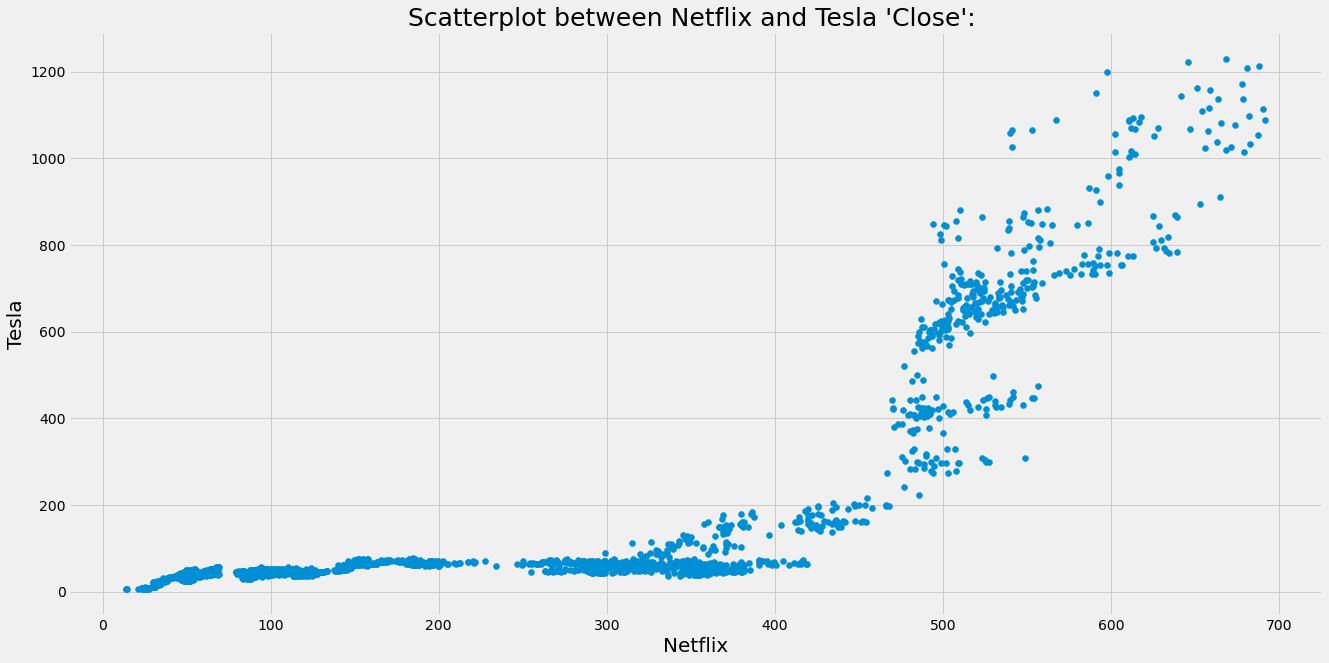

In [25]:
plt.scatter(df_new.Netflix, df_new.Tesla)
plt.ylabel('Tesla',fontsize = 20)
plt.xlabel('Netflix',fontsize = 20)
plt.title(f"Scatterplot between Netflix and Tesla 'Close': ", fontsize = 25)

### We did not reach a concrete conclusion about the connection between them because we did not find a "graphic connection".

#### Now, after we finished taking care and explore our data.

#### It's time to create our Model, starting with Machine Learning.

#### for doing that we will choose one stock from our already exsiting group.

# Machine learning:

In [26]:
print("Please Insert Yes/No to the following Question")
for i , code in enumerate(company_df,0):
    ok = input(f"Build The model on : {stock_name[i]}? ")
    if (ok == 'Yes') or (ok == 'yes'):
        data = code.copy()
        break
    else: 
        continue

Please Insert Yes/No to the following Question
Build The model on : Apple? no
Build The model on : Netflix? Yes


In [27]:
data['Date'] =pd.to_datetime(data['Date'])
data.set_index(["Date"],inplace = True)
data = data.sort_values(by=['Date'])

In [28]:
data

Open    High     Low   Close  Adj Close     Volume  Company
Date                                                                     
2011-09-15   25.25   26.49   24.02   24.18      24.18  148744400  Netflix
2011-09-16   23.97   24.00   22.02   22.17      22.17  124931800  Netflix
2011-09-19   22.38   23.28   20.37   20.54      20.54  139805400  Netflix
2011-09-20   20.20   20.43   18.48   18.58      18.58  224343000  Netflix
2011-09-21   18.63   19.18   17.86   18.36      18.36  158463900  Netflix
...            ...     ...     ...     ...        ...        ...      ...
2022-01-05  592.00  592.84  566.88  567.52     567.52    4148700  Netflix
2022-01-06  554.34  563.36  542.01  553.29     553.29    5711800  Netflix
2022-01-07  549.46  553.43  538.22  541.06     541.06    3381700  Netflix
2022-01-10  538.49  543.69  526.32  539.85     539.85    4486100  Netflix
2022-01-11  536.99  543.91  530.07  540.84     540.84    3072000  Netflix

[2599 rows x 7 columns]

### We will take only 'Close' Column for the prediction model, no need for the rest because they are the same.

In [30]:
data

Close
Date              
2011-09-15   24.18
2011-09-16   22.17
2011-09-19   20.54
2011-09-20   18.58
2011-09-21   18.36
...            ...
2022-01-05  567.52
2022-01-06  553.29
2022-01-07  541.06
2022-01-10  539.85
2022-01-11  540.84

[2599 rows x 1 columns]

### Normalizing the values using MinMaxScaler Function.

In [33]:
dataset = data.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.02410819],
       [0.02116959],
       [0.01878655],
       ...,
       [0.7797807 ],
       [0.7780117 ],
       [0.77945906]])

### We splitted the Data into Train and Test(90% for train and 10% test)

#### We will use "LSTM" model for building, compilation and training our model.
#### Since we chose an issue that did not match the models presented to us in the lessons,
#### For example, we can not run "Linear Regression", this can be seen clearly in the graph "Close Through the Years for all Stocks".
#### We investigated and found that a model of the "LSTM" type solves the problem of data collection over time.

In [ ]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

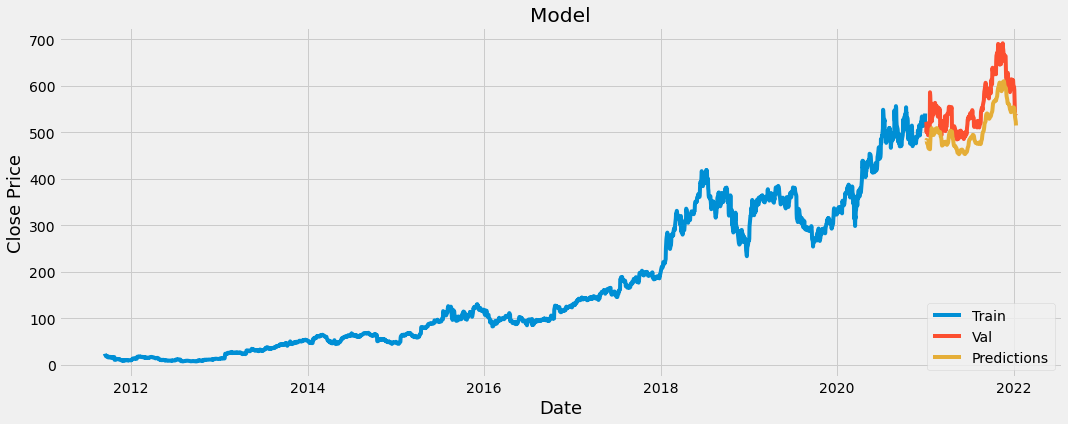

### Showing the Actual and Predictions on DataFrame.

In [42]:
Predicition_DataFrame

Close  Predictions
Date                           
2021-01-04  522.86    482.95477
2021-01-05  520.80    483.83826
2021-01-06  500.49    483.54370
2021-01-07  508.89    479.97333
2021-01-08  510.40    476.72238
...            ...          ...
2022-01-05  567.52    547.51580
2022-01-06  553.29    541.22210
2022-01-07  541.06    532.86710
2022-01-10  539.85    523.40000
2022-01-11  540.84    514.93494

[259 rows x 2 columns]

We researched online which model to use to predict a stock price

https://www.analyticsvidhya.com/blog/2021/10/machine-learning-for-stock-market-prediction-with-step-by-step-implementation/

https://neptune.ai/blog/predicting-stock-prices-using-machine-learning


